Day 9 - Diverging

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


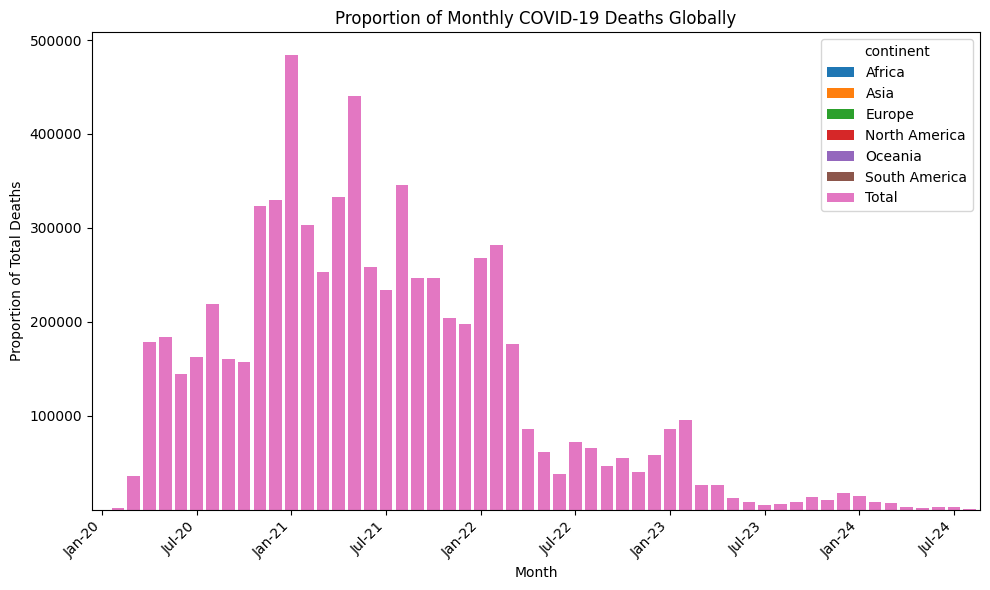

In [ ]:
# Day 9 - Diverging

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive

# Day 9 - Diverging
drive.mount('/content/gdrive')
df = pd.read_csv("/content/gdrive/My Drive/owid-covid-data.csv")
df.head()

# Filter out rows with missing data
df = df[df["continent"].notnull() & df["total_deaths"].notnull()].copy()

# Create a year-month column
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df["year_month"] = df["date"].dt.to_period("M")

# Compute monthly deaths per country
monthly_country = (
    df.groupby(["location", "continent", "year_month"])["total_deaths"]
    .max()
    .reset_index()
)

monthly_country["monthly_deaths"] = (
    monthly_country.groupby("location")["total_deaths"].diff().fillna(0)
)

# Group by continent and month
monthly_continent = (
    monthly_country.groupby(["continent", "year_month"])["monthly_deaths"]
    .sum()
    .reset_index()
)

# Convert period to timestamp
monthly_continent["year_month"] = monthly_continent["year_month"].dt.to_timestamp()

# Pivot data for stacked polar chart
pivot = monthly_continent.pivot(index="year_month", columns="continent", values="monthly_deaths").fillna(0)

# Sort columns to ensure consistent color ordering
pivot = pivot[sorted(pivot.columns)]

# Compute number of months and angle positions
num_months = len(pivot)
angles = np.linspace(0, 2 * np.pi, num_months, endpoint=False)

# Colors for continents
colors = {
    "Africa": "#1f77b4",
    "Asia": "#ff7f0e",
    "Europe": "#2ca02c",
    "North America": "#d62728",
    "Oceania": "#9467bd",
    "South America": "#8c564b"
}

# Diverging Bars
pivot['Total'] = pivot.sum(axis=1)
pivot_diverging = pivot.copy()
for col in pivot.columns[:-1]:  # Exclude the 'Total' column
    pivot_diverging[col] = pivot[col] / pivot['Total']

fig, ax = plt.subplots(figsize=(10, 6))
pivot_diverging.plot(kind="bar", stacked=True, ax=ax, width=0.8) # added width parameter

ax.set_xlabel("Month")
ax.set_ylabel("Proportion of Total Deaths")
ax.set_title("Proportion of Monthly COVID-19 Deaths Globally")

# Customize x-axis labels to show every 6th month
every_sixth_month = pivot_diverging.index[::6]
ax.set_xticks(range(0, len(pivot_diverging), 6))
ax.set_xticklabels([month.strftime('%b-%y') for month in every_sixth_month], rotation=45, ha="right")

# Customize legend (optional)
#plt.legend(title="Continent", loc="upper right", bbox_to_anchor=(1.2, 1))

plt.tight_layout()
plt.show()
